# Creating an Adder Circuit

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

### Encoding the input

To encode a binary string as input we need a `NOT` gate: the most basic operation you can do in a computer. It simply flips the bit value: 0 -> 1 and 1 -> 0.
For quantum computers, it is an operation called `X`.
In qiskit, the operations is called `x`.

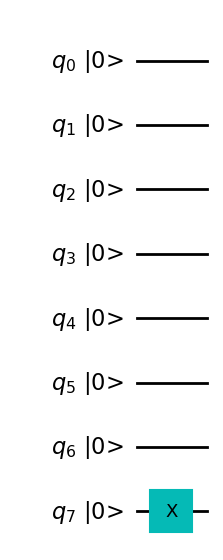

In [4]:
# Create a Quantum Circuit acting as a string encoder
qc_encode = QuantumCircuit(8)
qc_encode.x(7)
qc_encode.draw(output='mpl', initial_state=True)

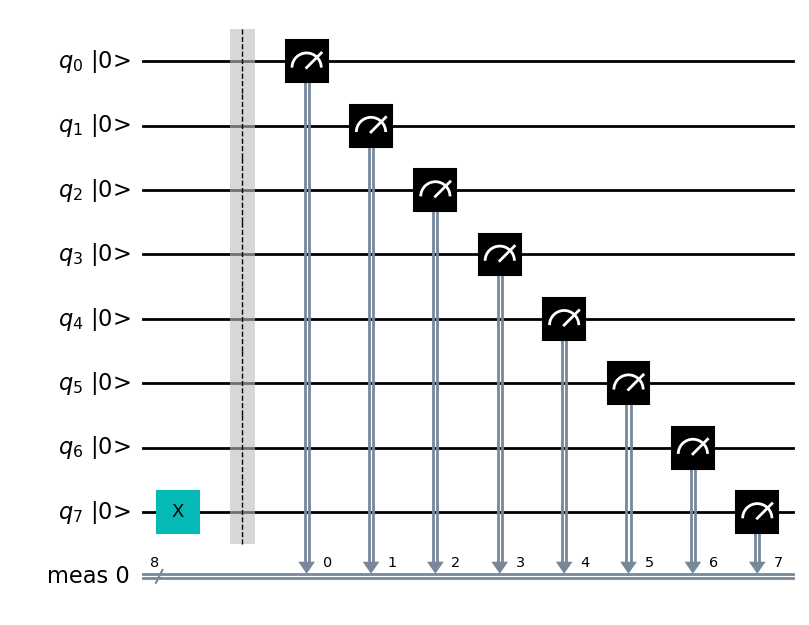

In [5]:
# Extracting result can be done by adding measurements
qc_encode.measure_all()
qc_encode.draw(output='mpl', initial_state=True)

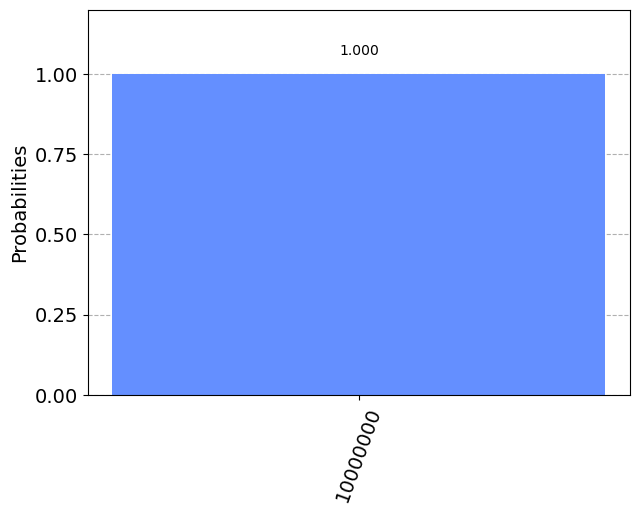

In [6]:
# run the combined circuit and look at the result
sim = Aer.get_backend('aer_simulator')
result = sim.run(qc_encode, shots=1024).result()
hist = result.get_counts()
plot_histogram(hist)

The computer outputs `10000000` with certainty. It means that qubit '7' is telling us about how many $ 2^7 $ s we have in our number. So, by flipping this bit, we've wrritten the number 128 in our simple 8-bit computer

### Half Adder

If we break everything down into adding just two bits, there are only four possible thing we'll ever need to calculate. Here are the **four basic sums**:
* `0+0 = 00 (in decimal, this is 0+0=0)`
* `0+1 = 01 (in decimal, this is 0+1=1)`
* `1+0 = 01 (in decimal, this is 1+0=1)`
* `1+1 = 10 (in decimal, this is 1+1=2)`

These are the rules our half adder must implement: once we have it, we can chain *multiple HAs* togheter and add anything

#### Adding with Qiskit

Let's make our own half adder using Qiskit. This will include:
1. a part of the circuit that encodes the input
2. a part that executes the algorithm
3. a part that extracts the result

> **nb:**  1. need to be changed whenever we want to use a new input, but the other parts remain the same.

To see what we need, let's take another look at what our HA needs to do:

* `0+0 = 00`
* `0+1 = 01`
* `1+0 = 01`
* `1+1 = 10`

The righmost bit is determined by whether the two qubits we are adding are the same or different:
* If equals -> 0
* if different -> 1

in classical computers, this is called an XOR gate.
In quantum computers, this operation is called `CNOT` (controlled not).
In qiskit, its name is `cx`.

The two bit we want to add are encoded in the qubits 0 and 1. The result will be a string of two qubits, which we will read out from qubits 2 and 3 and store in classical bits 0 and 1, respectively.

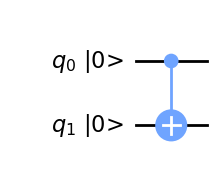

In [7]:
"""
The CNOT looks at the two input qubits and check whether they are the same.
Next, it overwrites the target qubits with the answer:
    equals -> 0
    different -> 1.
"""
qc_cnot = QuantumCircuit(2)
qc_cnot.cx(control_qubit=0, target_qubit=1)
qc_cnot.draw(output='mpl', initial_state=True)


Try the CNOT with each possible input

In: (q1, q0) -> Out: (q1, q0)

1. `00` -> `00` 
2. `01` -> `11`
3. `10` -> `10`
4. `11` -> `01`

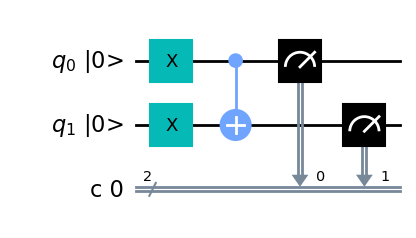

In [8]:
qc = QuantumCircuit(2,2)
qc.x(0)
qc.x(1)
qc.cx(0,1)
qc.measure(0,0)
qc.measure(1,1)
qc.draw(output='mpl', initial_state=True)

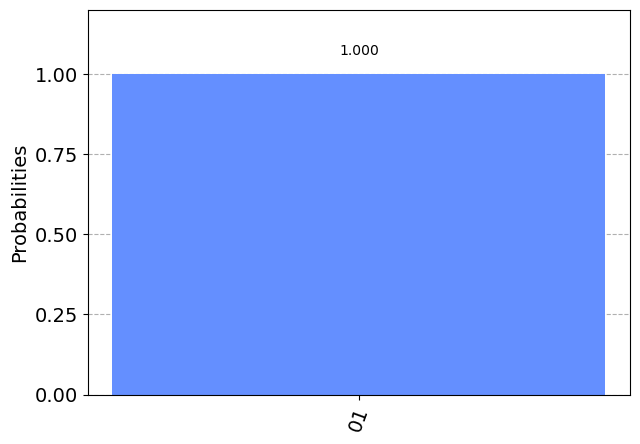

In [9]:
# execute the circuit
sim = Aer.get_backend('aer_simulator')
result = sim.run(qc, shots=1024).result()
hist =  result.get_counts()
plot_histogram(hist)

The execution of the circuit can be explained according the following reasons:
1. The `CNOT` calculates whether the input values are different and finds that they are -> it outputs `1` by overwriting the state of `target bit` 'q1'.
2. The `CNOT` sees that q0 is in state '1' -> applies `NOT` to q1, that is flipped from `0` to `1`.

> **nb:** For our HA, we don't want to overwrite on of our inputs.\
Instead, we want to write the result on a different pair of qubits. For this, we can use two CNOTs 

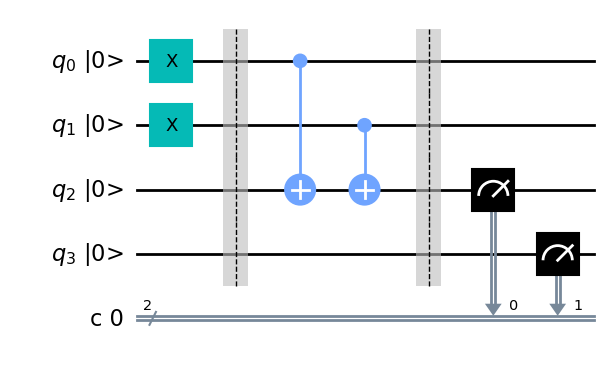

In [10]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in q0 and q1
qc_ha.x(0) # set q0 to 1
qc_ha.x(1) # set q1 to 1
qc_ha.barrier()
# use cnots to write the XOR of the inputs on q2
qc_ha.cx(0,2) # q0 XOR q2
qc_ha.cx(1,2) # q1 XOR (q0 XOR q2) -> since q2 is set to 0, we have: q1 XOR q0, i.e. the XOR of the inputs
qc_ha.barrier()
# measure the output
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # ... wait for it

# draw the circuit
qc_ha.draw(output='mpl', initial_state=True)

We are halway to a **fully working HA**: we just have the other bit of the output to do. Look again at the possible sum: there is only one case for which this is '1' instead of '0': `1 + 1 = 10`.

To calculate this part of the output, we need a gate that flips the target bit only if the two inputs bit are '1'.

In Quantum Computers there's a gate for this work, and it is a double controlled gate.\
This gate is called `Toffoli`: it performs a `NOT` on the target only when *both controls* are set to '1'.\
In Qiskit it is called `ccx`.


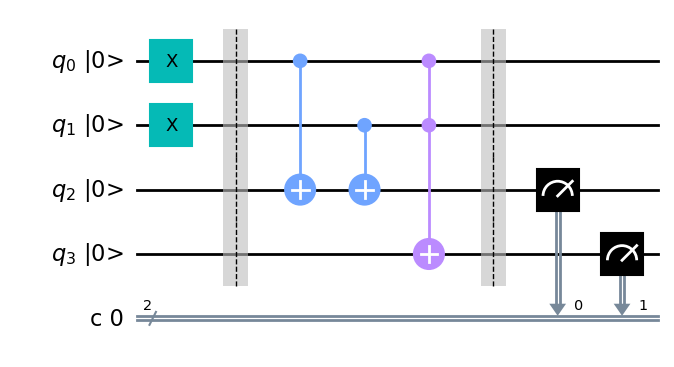

In [11]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in q0 and q1
qc_ha.x(0) # set q0 to 1
qc_ha.x(1) # set q1 to 1
qc_ha.barrier()
# use cnots to write the XOR of the inputs on q2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# use ccx to write the AND of the inputs on q3
qc_ha.ccx(0,1,3)
qc_ha.barrier()
# measure the output
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # extract AND value

# draw the circuit
qc_ha.draw(output='mpl', initial_state=True)

In this example we are computing `1 + 1`: let's see what we get.

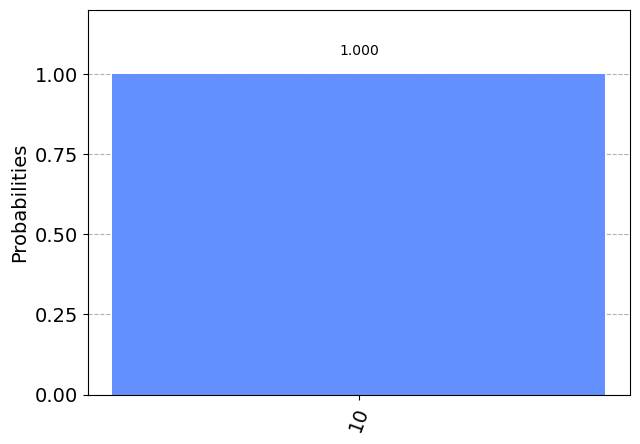

In [12]:
qobj = assemble(qc_ha)
counts = sim.run(qobj, shots=1024).result().get_counts()
plot_histogram(counts)

The result is `10`, which is the binary representation of the number 2. We have built aa computer that can solve the famouse mathematic problem of 1+1!

#### Try the 1 bit Adder with all possible inputs:

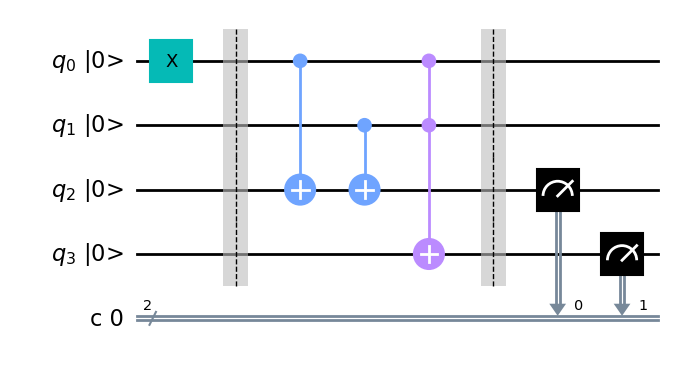

In [13]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in q0 and q1
qc_ha.x(0) # set q0 to 1
#qc_ha.x(1) # set q1 to 1
qc_ha.barrier()
# use cnots to write the XOR of the inputs on q2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# use ccx to write the AND of the inputs on q3
qc_ha.ccx(0,1,3)
qc_ha.barrier()
# measure the output
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # extract AND value

# draw the circuit
qc_ha.draw(output='mpl', initial_state=True)

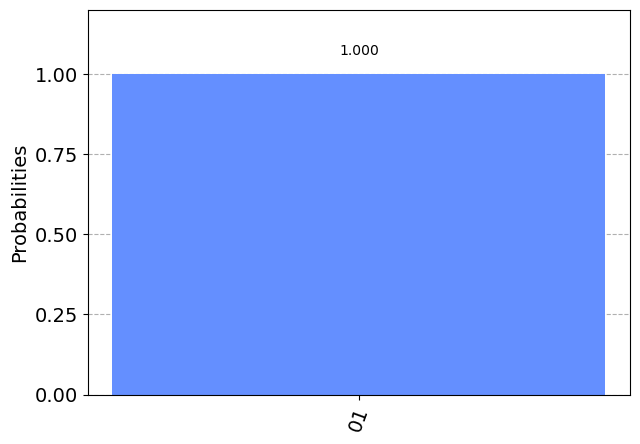

In [14]:
qobj = assemble(qc_ha)
counts = sim.run(qobj, shots=1024).result().get_counts()
plot_histogram(counts)

### Full Adder

A FA is a logic circuit based by classical computers to implement addition up to 3 bits: 
INPUTS:
* A
* B
* C_IN (carry from previous FA)

OUTPUTS:
* SUM
* C_OUT (carry out)


To implement a FA on a quantum computer we will need 5 qubits:

* `q0: qubit for input A`
* `q1: qubit for input B`
* `q2: qubit for input C_IN`
* `q3: qubit for output SUM`
* `q4: qubit for output C_OUT`

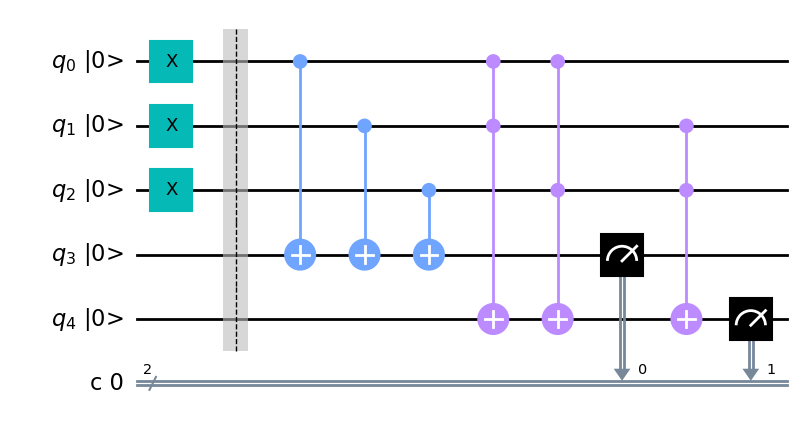

In [22]:
qc_fa = QuantumCircuit(5,2)

qc_fa.x(0) # set q0 to 1
qc_fa.x(1) # set q1 to 1
qc_fa.x(2) # set q2 (C_IN) to 1
qc_fa.barrier()
# use cnots to write the XOR of the inputs on q3
qc_fa.cx(0,3) # q0 XOR q3
qc_fa.cx(1,3) # (q0 XOR q3) XOR q1 -> since q3 is set to 0, we have: q0 XOR q1, i.e. the XOR of the inputs
qc_fa.cx(2,3) # q0 XOR q1 XOR q2
qc_fa.ccx(0,1,4) # q0 AND q1
qc_fa.ccx(0,2,4) # (q0 AND q1) XOR (q0 AND q2)
# Measure the SUM
qc_fa.measure(3,0) # extract the SUM value
# finish computing the C_OUT
qc_fa.ccx(1,2,4) # (q0 AND q1) XOR (q0 AND q2) XOR (q1 AND q2)
# Measure the C_OUT
qc_fa.measure(4,1) # extract the C_OUT value

# draw the circuit
qc_fa.draw(output='mpl', initial_state=True)

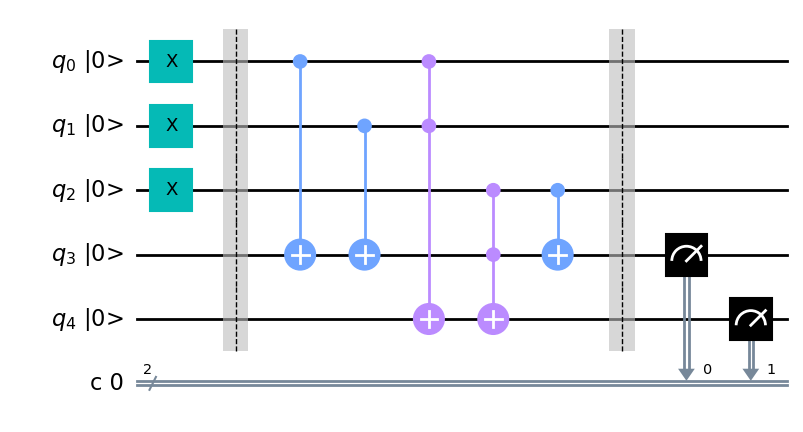

In [50]:
qc_fa = QuantumCircuit(5,2)

qc_fa.x(0) # set q0 to 1
qc_fa.x(1) # set q1 to 1
qc_fa.x(2) # set q2 (C_IN) to 1
qc_fa.barrier()
# use cnots to write the XOR of the inputs on q3
qc_fa.cx(0,3) # q0 XOR q3
qc_fa.cx(1,3) # (q0 XOR q3) XOR q1 -> since q3 is set to 0, we have: q0 XOR q1, i.e. the XOR of the inputs


qc_fa.ccx(0,1,4)
qc_fa.ccx(2,3,4)

qc_fa.cx(2,3)

qc_fa.barrier()
qc_fa.measure(3,0) # extract the SUM value
qc_fa.measure(4,1) # extract the C_OUT value

# draw the circuit
qc_fa.draw(output='mpl', initial_state=True)

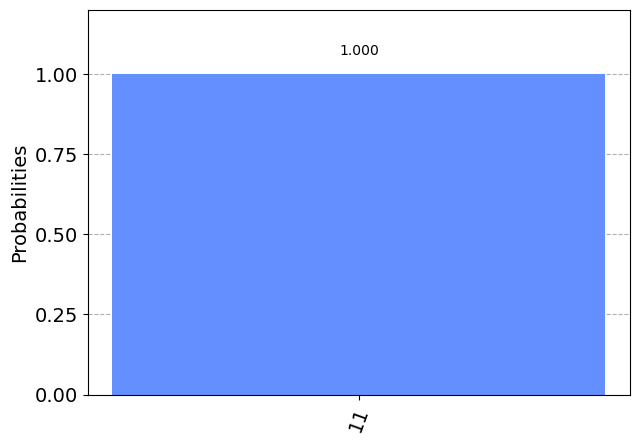

In [51]:
qobj = assemble(qc_fa)
counts = sim.run(qobj, shots=1024).result().get_counts()
plot_histogram(counts)